1. Recopilaremos los datos historicos de precio, capitalizacion de mercado y volumen de transacciones de cada cryptomoneda elejida de los ultimos 5 años. Seran los datos de cierre de cada dia.
2. Buscaremos los datos de variacion porcentual de precio que tuvo cada dia con respecto al anterior
3. Añadiremos la tendencia del precio de cada crypto. Para eso utilizaremos la media movil de 15 dias (Sin tener en cuenta el dato propio de la fecha para no generar tendencias engañozas). 
4. Vamos a tener en cuenta tambien la relacion precio / MA15, para saber en que posicion se encuentra el precio con la tendencia. 
4. Añadiremos el volumen dividido la capitalizacion de mercado, para saber la liquidez relativa de cada moneda.
5. Por ultimo, una columna con el valor absoluto del porcentaje de cambio de precios de cada dia.<br><br>


- Analizaremos mediante graficos de histogramas (seperados por cryptomonedas) las distintas medidas obtenidas.
- Haremos un heatmap de correlacion entre todas las variables elejidas para saber si podemos encontrar alguna tendencia que nos oriente hacia oportunidades de compra de las distintas cryptomonedas.

A partir del analisis que obtengamos haremos operaciones de compra en base a ciertas metricas, luego evaluaremos los resultados con un "backtesting"


In [445]:
import pandas as pd
import requests
from datetime import datetime, timedelta

cryptos_elejidas = pd.read_csv('C:/Users/Benja/Desktop/PI_DA/cryptos_elejidas.csv')

def get_price_percentage_df(crypto_ids=[], dias=0):
    def fetch_historical_data(coin_id):
        base_url = "https://api.coingecko.com/api/v3"
        end_time = datetime.now()
        start_time = end_time - timedelta(days=dias) 
        
        from_timestamp = int(start_time.timestamp())
        to_timestamp = int(end_time.timestamp())
        
        response = requests.get(f"{base_url}/coins/{coin_id}/market_chart/range",
                                params={
                                    'vs_currency': 'usd',
                                    'from': from_timestamp,
                                    'to': to_timestamp
                                })
        data = response.json()
      
        return data

    all_data = []
    
    for coin_id in crypto_ids:
        data = fetch_historical_data(coin_id)
        
        if 'prices' in data and 'market_caps' in data:
            # Creamos DataFrames para precios, market_cap y volume
            df_price = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
            df_market_cap = pd.DataFrame(data['market_caps'], columns=['timestamp', 'market_cap'])
            
            if 'total_volumes' in data:
                df_volume = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'volume'])
            else:
                df_volume = pd.DataFrame(columns=['timestamp', 'volume'])
         
            df = pd.merge(df_price, df_market_cap, on='timestamp')
            df = pd.merge(df, df_volume, on='timestamp', how='left')
            
            df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
            df['id_moneda'] = coin_id
            df['Porcentaje'] = df['price'].pct_change() * 100
            df['market_cap'] = df['market_cap'] / 1000000
           
            df = df[['date', 'id_moneda', 'price', 'Porcentaje', 'market_cap', 'volume']]
            
            all_data.append(df)

    final_df = pd.concat(all_data, axis=0).reset_index(drop=True)

    return final_df




Recopilacion de datos.

In [446]:
cryptos_elejidas = pd.read_csv('C:/Users/Benja/Desktop/PI_DA/cryptos_elejidas.csv')
crypto_list = cryptos_elejidas['id'].tolist()
df = get_price_percentage_df(crypto_list, 1825)

Agregamos columnas que nos interesan.

In [448]:
df['MA_15'] = df['price'].shift(1).rolling(window=15).mean()
df['Price_to_MA15'] = df['price'] / df['MA_15']
df['Volume_to_market_cap'] = df['volume'] / (df['market_cap']*10000)
df['Porcentaje_abs'] = df['Porcentaje'].abs()
df['std_porcentaje'] = df['Porcentaje'].shift(1).rolling(window=15).std()


Elimino los valores NaN y inf creados.

In [449]:
import numpy as np
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=df.columns, how="any")

Histogramas de precios sobre tendencias.

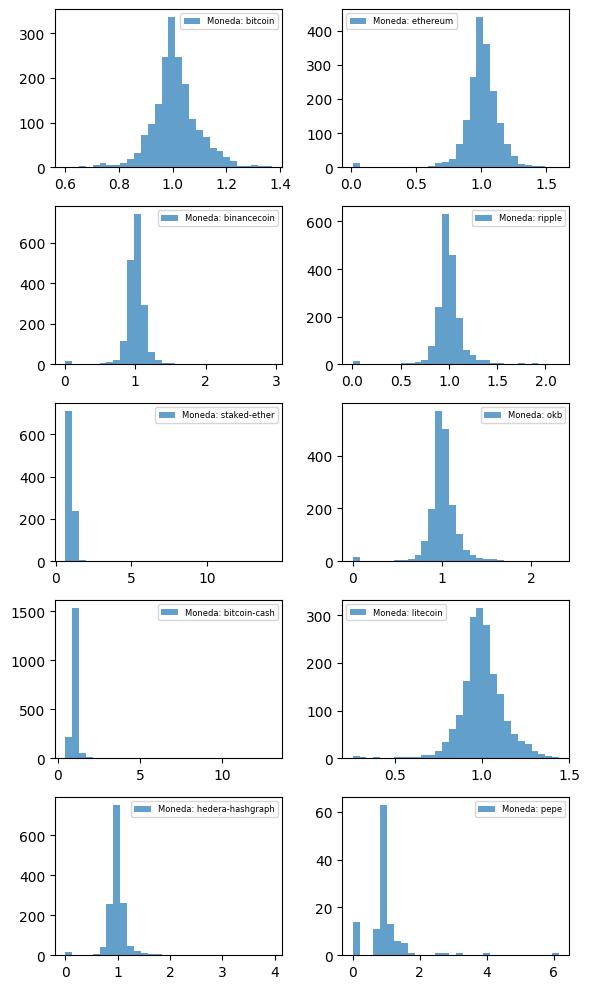

In [450]:
import numpy as np

unique_ids = df['id_moneda'].unique()

n_rows = int(np.ceil(len(unique_ids) / 2))

fig, axes = plt.subplots(n_rows, 2, figsize=(6, 2 * n_rows))

axes = axes.ravel()

for i, uid in enumerate(unique_ids):
    subset = df[df['id_moneda'] == uid]
    axes[i].hist(subset['Price_to_MA15'], bins=30, alpha=0.7, label=f'Moneda: {uid}')
    axes[i].legend(fontsize=6)


plt.tight_layout()
plt.show()



Histogramas de porcentajes de variacion por dia. (Volatilidad)

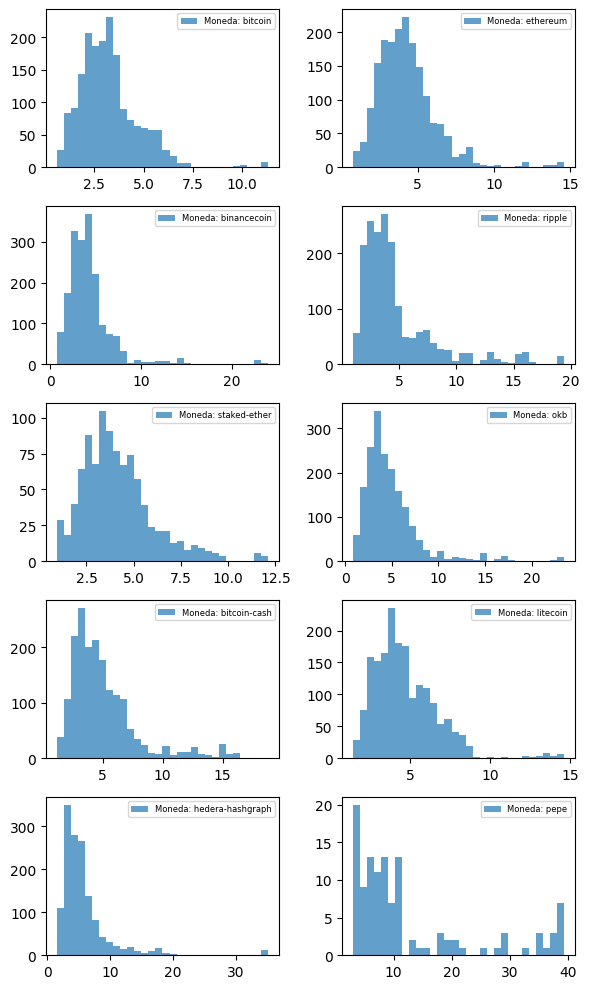

In [451]:
import numpy as np

unique_ids = df['id_moneda'].unique()

n_rows = int(np.ceil(len(unique_ids) / 2))

fig, axes = plt.subplots(n_rows, 2, figsize=(6, 2 * n_rows))

axes = axes.ravel()

for i, uid in enumerate(unique_ids):
    subset = df[df['id_moneda'] == uid]
    axes[i].hist(subset['std_porcentaje'], bins=30, alpha=0.7, label=f'Moneda: {uid}')
    axes[i].legend(fontsize=6)


plt.tight_layout()
plt.show()


Histogramas de volume_to_market_cap por cryptomoneda.(Liquidez relativa)

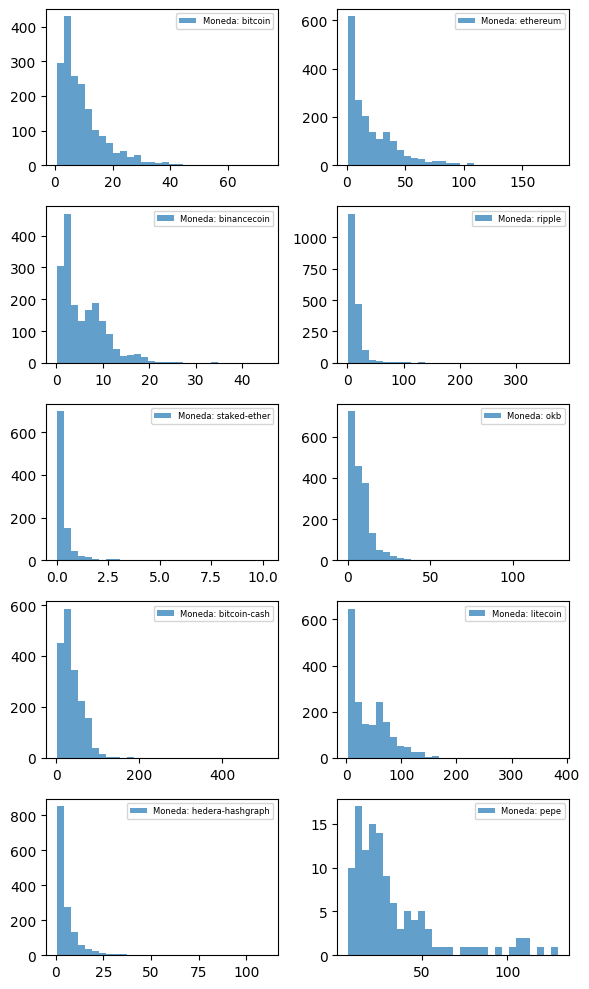

In [452]:
import numpy as np

unique_ids = df['id_moneda'].unique()

n_rows = int(np.ceil(len(unique_ids) / 2))

fig, axes = plt.subplots(n_rows, 2, figsize=(6, 2 * n_rows))

axes = axes.ravel()

for i, uid in enumerate(unique_ids):
    subset = df[df['id_moneda'] == uid]
    axes[i].hist(subset['Volume_to_market_cap'], bins=30, alpha=0.7, label=f'Moneda: {uid}')
    axes[i].legend(fontsize=6)


plt.tight_layout()
plt.show()



Heatmap de correlaciones.

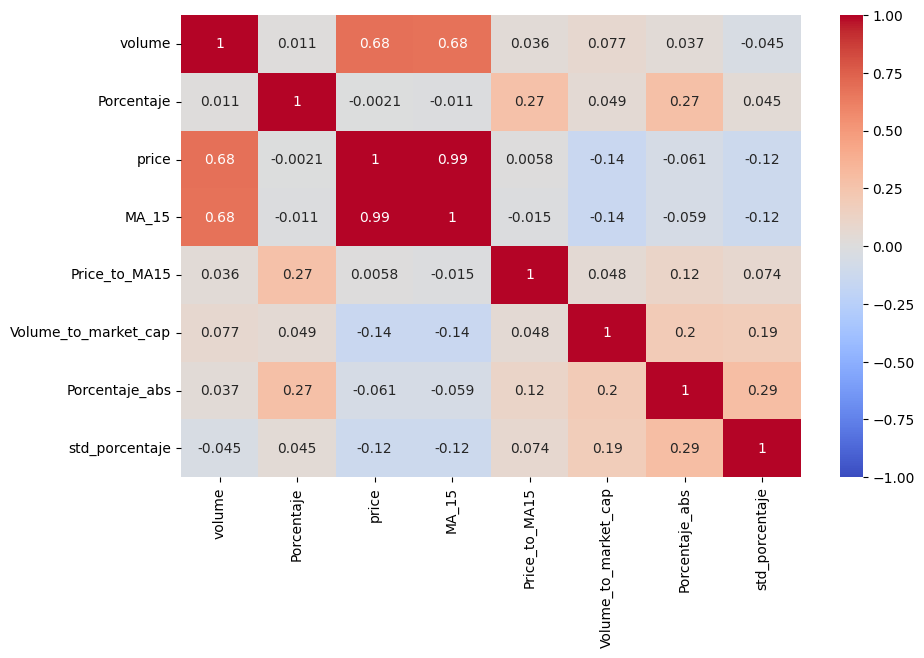

In [453]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[["volume", "Porcentaje","price",'MA_15','Price_to_MA15','Volume_to_market_cap','Porcentaje_abs','std_porcentaje']].corr()

plt.figure(figsize=(10, 6)) # Ajustar tamaño según lo que necesites
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [167]:
df.to_csv('precios_cryptos.csv', index=False)

Habiendo hecho un analisis de las diferentes variables vamos a realizar operaciones de compra cuando se cumplan la siguientes condiciones:
- Price_to_MA15 pase de menor que 1 a mayor que 1 (Con el requerimiento de venir 5 dias negativos seguidos)
- Volume_to_market_cap este dentro del 0.75 mas alto de cada crypto individualmente.
- std_porcentaje debe ser este dentro del 0.25 mas bajo de cada crypto individualmente.

Hacemos un dataframe de operaciones de compra cuando se cumplen lo mencionado anteriormente.

In [454]:
df_operaciones = df


In [455]:

df_operaciones['is_negative'] = df_operaciones['Price_to_MA15'] < 1

df_operaciones['last_5_days_negative'] = df_operaciones['is_negative'].rolling(window=5).sum() == 5

df_operaciones['change_to_positive'] = df_operaciones['is_negative'].shift(1) & (~df_operaciones['is_negative'])

df_operaciones['condition_met'] = df_operaciones['last_5_days_negative'].shift(1) & df_operaciones['change_to_positive']


In [456]:

df_operaciones['high_volume_condition'] = df_operaciones['Volume_to_market_cap'] > df_operaciones.groupby('id_moneda')['Volume_to_market_cap'].transform(lambda x: x.quantile(0.75))
df_operaciones['low_std_condition'] = df_operaciones['std_porcentaje'] <= df_operaciones.groupby('id_moneda')['std_porcentaje'].transform(lambda x: x.quantile(0.25))
df_operaciones['filtro_fecha'] = df_operaciones['date'] > '2023-01-01'

In [457]:
# Establecemos la condición de compra
df_operaciones['buy_condition'] = (df_operaciones['condition_met'] & 
                                  ((df_operaciones['high_volume_condition']) | 
                                   (df_operaciones['low_std_condition'])) & 
                                  df_operaciones['filtro_fecha'])

inversion = 1000

# Establecemos la cantidad de unidades compradas basada en la condición de compra
df_operaciones['Unidades_compradas'] = np.where(df_operaciones['buy_condition'], 
                                               inversion / df_operaciones['price'], 
                                               0)

df_operaciones['Venta'] = 0

# Para cada fila donde hay una compra, encuentra la fila que está 5 días después y registra la venta
for index, row in df_operaciones[df_operaciones['buy_condition']].iterrows():
    fecha_venta = row['date'] + pd.Timedelta(days=5)
    idx_venta = df_operaciones[(df_operaciones['date'] == fecha_venta) & 
                               (df_operaciones['id_moneda'] == row['id_moneda'])].index
    
    if not idx_venta.empty:
        df_operaciones.at[idx_venta[0], 'Venta'] = row['Unidades_compradas'] * df_operaciones.at[idx_venta[0], 'price']

df_operaciones['Compra'] = np.where(df_operaciones['buy_condition'], inversion, 0)

# Dropear columnas innecesarias
columns_to_drop = ['Unidades_compradas','condition_met', 'high_volume_condition', 'low_std_condition', 'filtro_fecha', 'buy_condition','std_porcentaje','Porcentaje_abs','Volume_to_market_cap','Price_to_MA15','MA_15','volume','market_cap','Porcentaje','last_5_days_negative','is_negative','change_to_positive']
df_operaciones.drop(columns_to_drop, axis=1, inplace=True)

# Calcular totales
total_compras = df_operaciones['Compra'].sum()
total_ventas = df_operaciones['Venta'].sum()

print(total_ventas - total_compras)
print(total_compras/1000)




1459.780791585712
60.0


In [458]:
df_operaciones

,date,id_moneda,price,Venta,Compra
16,2018-09-02,bitcoin,7211.270768,0.0,0
17,2018-09-03,bitcoin,7305.272801,0.0,0
18,2018-09-04,bitcoin,7260.897517,0.0,0
19,2018-09-05,bitcoin,7359.462993,0.0,0
20,2018-09-06,bitcoin,6764.926774,0.0,0
...,...,...,...,...,...
15285,2023-08-11,pepe,0.000001,0.0,0
15286,2023-08-12,pepe,0.000001,0.0,1000
15287,2023-08-13,pepe,0.000001,0.0,0
15288,2023-08-14,pepe,0.000001,0.0,0


In [459]:
df_operaciones.to_csv('operaciones_cryptos.csv', index=False)

In [460]:
df_compras_ventas = df[(df['Compra'] != 0) | (df['Venta'] != 0)]
df_compras_ventas

,date,id_moneda,price,Venta,Compra
1602,2023-01-05,bitcoin,16855.174739,0.000000,1000
1607,2023-01-10,bitcoin,17194.909329,1020.156100,0
1644,2023-02-16,bitcoin,24307.875102,0.000000,1000
1649,2023-02-21,bitcoin,24786.665941,1019.696943,0
1670,2023-03-14,bitcoin,24178.955328,0.000000,1000
...,...,...,...,...,...
15159,2023-08-05,hedera-hashgraph,0.053283,0.000000,1000
15164,2023-08-10,hedera-hashgraph,0.059785,1122.034826,0
15186,2023-05-04,pepe,0.000001,0.000000,1000
15191,2023-05-09,pepe,0.000002,1772.585639,0


KPI

- Retorno de inversion
- Porcentaje de Operaciones positivas
- Rendimiento / Valor en Riesgo (VaR)